In [1]:
import numpy as np
import torch
import torch.nn as nn
import numba
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
torch.manual_seed(0)

print("Numpy version", np.__version__)
print("Torch version", torch.__version__)
print("Numba version", numba.__version__)

Numpy version 1.23.5
Torch version 2.1.0.dev20230419+cu117
Numba version 0.57.1


In [2]:
from batchdilate import DTWShpTime

In [3]:
batch_size = 128
num_channels = 10 # different "parallel" timeseries
num_outputs = 100 # number of future timesteps predicted


loc = torch.tensor([1.] * num_outputs)
scale = torch.tensor([1.] * num_outputs)
prediction = torch.normal(mean=loc, std=scale).repeat(batch_size, num_channels, 1).to(device)
prediction.shape

torch.Size([128, 10, 100])

In [4]:
target = torch.sin(torch.arange(num_outputs).float()).repeat(batch_size, num_channels, 1).to(device)
target.shape

torch.Size([128, 10, 100])

In [5]:
# use a dummy model as a "prediction" module. we'll use this to verify that gradient propagate
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor([1.], device=device))
        
    def forward(self, x):
        return x + self.bias
    
model = DummyModel()
prediction = model(prediction)

In [6]:
prediction.shape

torch.Size([128, 10, 100])

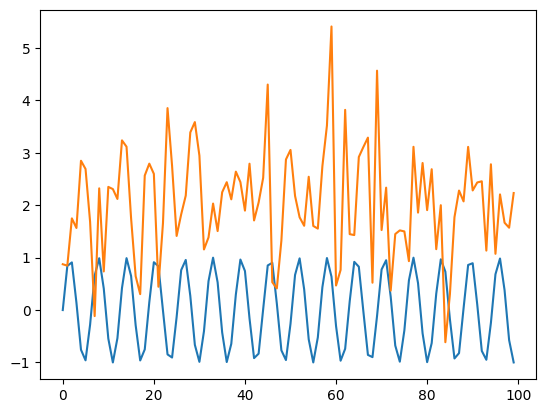

In [7]:
batch_id_to_plot = 0
channel_to_plot = 0
plt.plot(target[batch_id_to_plot, channel_to_plot].cpu().numpy())
plt.plot(prediction[batch_id_to_plot, channel_to_plot].detach().cpu().numpy())

In [8]:
# for demo purposes we'll use no reduction
batch_dilate_loss_criterion = DTWShpTime(alpha=0.4, gamma=0.01, reduction="none")

total_loss, shape_loss, temporal_loss = batch_dilate_loss_criterion(prediction, target)

In [9]:
total_loss, shape_loss, temporal_loss

(tensor([[121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652],
         [121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652],
         [121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652],
         ...,
         [121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652],
         [121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652],
         [121.7652, 121.7652, 121.7652,  ..., 121.7652, 121.7652, 121.7652]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192],
         [270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192],
         [270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192],
         ...,
         [270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192],
         [270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192],
         [270.6192, 270.6192, 270.6192,  ..., 270.6192, 270.6192, 270.6192

In [10]:
# verifying that total_loss = alpha * shape_loss + (1-alpha) * temporal_loss
assert torch.allclose(torch.mean(0.4 * shape_loss + (1 - 0.4) * temporal_loss),
                      total_loss)

In [11]:
# verify that the gradients are being computed properly
torch.autograd.grad(total_loss.mean(), model.bias)

(tensor([89.8253], device='cuda:0'),)